In [46]:
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from transformers import BertModel, BertTokenizer

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

# 1. Sentence embeddings 

### Load pretrained BERT model

In [47]:
# Load pretrained model/tokenizer
model_name_or_path = '../models/netbert/checkpoint-1027000/'  #'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../cache') # Will output all hidden_states.

### Load sentences

In [48]:
filepath = './data/computer_network.csv'
df = pd.read_csv(filepath)
sentences = df.Sentence.values

# Add classes ids column.
labels = df.Label.unique()
df['Label_id'] = df.apply(lambda row: np.where(labels == row.Label)[0][0], axis=1)

# Print details.
print('Number of sentences: {}\n'.format(df.shape[0]))
print('Number of labels: {:,}'.format(len(labels)))
for i, lab in enumerate(labels):
    print("  {} : {}".format(lab, i))

# Example
random.seed(42)
print("\nExample:\n\n{}".format(random.choice(sentences)))
df.sample(10)

Number of sentences: 155

Number of labels: 15
  Computer network : 0
  History : 1
  Properties : 2
  Network packet : 3
  Network topology : 4
  Network links : 5
  Network nodes : 6
  Communication protocols : 7
  Geographic scale : 8
  Organizational scope : 9
  Routing : 10
  Network service : 11
  Network performance : 12
  Security : 13
  Views of networks : 14

Example:

Packets consist of two kinds of data: control information and user data (payload). The control information provides data the network needs to deliver the user data, for example, source and destination network addresses, error detection codes, and sequencing information. Typically, control information is found in packet headers and trailers, with payload data in between.


,Sentence,Label,Label_id
81,IEEE 802 is a family of IEEE standards dealing...,Communication protocols,7
7,"In 1959, the MOSFET (MOS transistor) was inven...",History,1
74,A network switch is a device that forwards and...,Network nodes,6
44,Overlay networks have also been proposed as a ...,Network topology,4
80,"There are many communication protocols, a few ...",Communication protocols,7
62,"Both cases have a large round-trip delay time,...",Network links,5
56,Cellular networks use several radio communicat...,Network links,5
114,Participants in the Internet use a diverse arr...,Organizational scope,9
61,Extending the Internet to interplanetary dimen...,Network links,5
3,The chronology of significant computer-network...,History,1


### Tokenization

In [49]:
# Tokenization in multiple steps.
marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]

# Tokenization in one step.
tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

# Example.
print("Example:\n")
random.seed(42)
print(random.choice(marked_text))
random.seed(42)
print(random.choice(tokenized_text))
random.seed(42)
print(random.choice(indexed_tokens))

Example:

[CLS] Packets consist of two kinds of data: control information and user data (payload). The control information provides data the network needs to deliver the user data, for example, source and destination network addresses, error detection codes, and sequencing information. Typically, control information is found in packet headers and trailers, with payload data in between. [SEP]
['[CLS]', 'Pack', '##ets', 'consist', 'of', 'two', 'kinds', 'of', 'data', ':', 'control', 'information', 'and', 'user', 'data', '(', 'payload', ')', '.', 'The', 'control', 'information', 'provides', 'data', 'the', 'network', 'needs', 'to', 'deliver', 'the', 'user', 'data', ',', 'for', 'example', ',', 'source', 'and', 'destination', 'network', 'addresses', ',', 'error', 'detection', 'codes', ',', 'and', 'se', '##quencing', 'information', '.', 'Typically', ',', 'control', 'information', 'is', 'found', 'in', 'packet', 'header', '##s', 'and', 'trailers', ',', 'with', 'payload', 'data', 'in', 'between',

### Padding

In [50]:
# Define length of longest sentence in our dataset.
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)
print("Maximum length: {}".format(max_len))
        
# Pad each tokenized sentence according to the maximum length.
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

# Example.
random.seed(42)
print("Example:\n    {}".format(random.choice(padded)))

Maximum length: 219
Example:
    [  101 14667  6248  8296  1104  1160  7553  1104  2233   131  1654  1869
  1105  4795  2233   113 21586   114   119  1109  1654  1869  2790  2233
  1103  2443  2993  1106  7852  1103  4795  2233   117  1111  1859   117
  2674  1105  7680  2443 11869   117  7353 11432  9812   117  1105 14516
 27276  1869   119 16304   117  1654  1869  1110  1276  1107 17745 23103
  1116  1105 24760   117  1114 21586  2233  1107  1206   119   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0

### Masking

In [51]:
attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

# Example.
random.seed(42)
print("Example:\n    {}".format(random.choice(attention_mask)))

Example:
    [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Convert to torch tensors

In [52]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

### Encode

In [53]:
with torch.no_grad():
    # output is a 2-tuple where:
    #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
    #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
    #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
    output = model(input_ids, attention_mask=attention_mask)

# Get individual components of the output.
last_hidden_states = output[0]
pooler_output = output[1]
hidden_states = output[2]

# Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
hidden_states = torch.stack(hidden_states, dim=0)

# Print dimensions of output.
print("Dimensions of hidden_states: {}".format(hidden_states.size()))
print("   - Number of layers (+1 with initial token embeddings): {}".format(hidden_states.size(0)))
print("   - Number of sentences: {}".format(hidden_states.size(1)))
print("   - Number of tokens in a sentence: {}".format(hidden_states.size(2)))
print("   - Dimension of an embedding : {}".format(hidden_states.size(3)))

Dimensions of hidden_states: torch.Size([13, 155, 219, 768])
   - Number of layers (+1 with initial token embeddings): 13
   - Number of sentences: 155
   - Number of tokens in a sentence: 219
   - Dimension of an embedding : 768


In [54]:
# Switch around the “layers” and “tokens” dimensions with permute.
hidden_states = hidden_states.permute(1,2,0,3)
hidden_states.size()

torch.Size([155, 219, 13, 768])

### Average last hidden layer

In [55]:
# For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
sentence_embeddings = [torch.mean(embeddings, dim=0).numpy() for embeddings in last_hidden_states]
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(155, 768)

# 2. Visualization

## 2.1. Tensorboard Projector

In [23]:
def generate_colors(x):
    """
    Generate x random colors.
    """
    return [tuple(np.random.uniform(low=0.0, high=1.0, size=3)) for i in range(x)]


# Load SummaryWriter (will output to ./runs/ directory by default).
writer = SummaryWriter()

# Get the labels and generate one color for each.
labels = df.Label.unique().tolist()

# Associate each sentence with the color of its label.
label_img = torch.zeros(len(sentence_embeddings), 3, 32, 32)
colors = generate_colors(len(labels))
for i in range(len(sentence_embeddings)):
    # Get color of that label.
    sentence_label = df.loc[i,'Label']
    idx = labels.index(sentence_label)
    color = colors[idx]
    
    # Set color.
    label_img[i,0,:,:] = color[0]
    label_img[i,1,:,:] = color[1]
    label_img[i,2,:,:] = color[2]

# Write to tensorboard
writer.add_embedding(sentence_embeddings, metadata=df.Sentence.values, label_img=label_img)

# Close writer
writer.close()

## 2.2. Manually

### Perform PCA

In [56]:
pca = PCA(n_components=3, random_state = 42)
pca_result = pca.fit_transform(sentence_embeddings)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13985895 0.07471794 0.04284582]


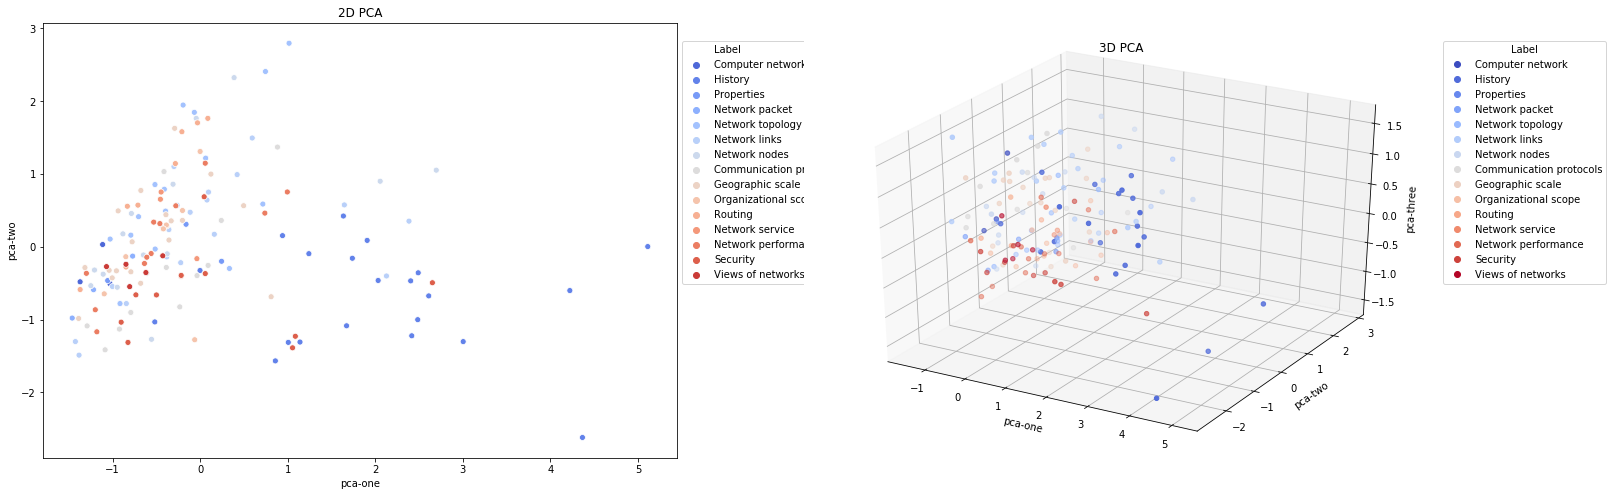

In [94]:
fig = plt.figure(figsize=(25,8))

# PCA in 2D
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(
    x = df['pca-one'], 
    y = df['pca-two'],
    hue = df["Label"],
    palette = "coolwarm")
ax1.set_title("2D PCA")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.68))

# PCA in 3D
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"],
    c=df["Label_id"],
    cmap='coolwarm')
handles,_ = scatter.legend_elements(num=len(labels))
ax2.legend(handles, labels, loc="center left", title="Label", bbox_to_anchor=(1, 0.68))
ax2.set_title("3D PCA")
ax2.set_xlabel('pca-one')
ax2.set_ylabel('pca-two')
ax2.set_zlabel('pca-three')
plt.show()

## Word vectors

### Sum the last four layers.

In [16]:
# Take the first sentence as a sample.
sample_sentence = hidden_states[0]  # `sample_sentence` is a [123 x 13 x 768] tensor.

# Stores the token vectors, with shape [123 x 768]
token_vecs_sum = []

# For each token in the sentence...(`token` is a [13 x 768] tensor)
for token in sample_sentence:
    
        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
        
        # Use `sum_vec` to represent `token`.
        token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 123 x 768


# Tests

In [52]:
# Example sentence.
sentence = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."

# Tokenization in multiple steps.
marked_text = "[CLS] " + sentence + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Tokenization in one step.
tokenized = tokenizer.encode(sentence, add_special_tokens=True)
tokenized = torch.tensor([tokenized])

# Encode it.
with torch.no_grad():
    output = model(tokenized)
    
# Get all hidden states.
hidden_states = output[2]
hidden_states = torch.stack(hidden_states, dim=0)
hidden_states = torch.squeeze(hidden_states, dim=1)
hidden_states = hidden_states.permute(1,0,2)
print(" - 'hidden_states' is a {} tensor.".format(hidden_states.size()))

# Sum the last four layers.
token_vecs_sum = []
for token in hidden_states:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)
print(" - 'token_vecs_sum' is a ({}, {}) array.".format(len(token_vecs_sum), len(token_vecs_sum[0])))

# Get idx of words of interest 'bank'.
for i, token_str in enumerate(tokenized_text):
    print(i, token_str)

# Calculate the cosine similarity between the word bank in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

 - 'hidden_states' is a torch.Size([24, 13, 768]) tensor.
 - 'token_vecs_sum' is a (24, 768) array.
0 [CLS]
1 After
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 r
12 ##ob
13 ##ber
14 was
15 seen
16 fishing
17 on
18 the
19 Mississippi
20 river
21 bank
22 .
23 [SEP]
Vector similarity for  *similar*  meanings:  0.90
Vector similarity for *different* meanings:  0.68
